Code from https://www.datacamp.com/tutorial/fine-tuning-llama-2

In [ ]:
!pip install pdfplumber

In [ ]:
import json

In [ ]:
data = []
testing_data = []
with open('dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [ ]:
import os
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "llama-2-7b-miniguanaco"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 5

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.0001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 5

# Log every X updates steps
logging_steps = 5

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Load dataset (you can process it here)
dataset = Dataset.from_list(data)
test_dataset = Dataset.from_list(testing_data)

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
from datasets import load_metric
import numpy as np
import matplotlib.pyplot as plt

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1).flatten()
    print(predictions.flatten())
    return metric.compute(predictions=predictions, references=labels.flatten(), average="macro")

<ipython-input-16-a270f1fe105c>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

In [ ]:
# Train model
trainer.train()

{'loss': 1.5766, 'learning_rate': 0.0002, 'epoch': 1.67}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.4592, 'learning_rate': 0.0002, 'epoch': 3.33}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.3585, 'learning_rate': 0.0002, 'epoch': 5.0}
{'train_runtime': 205.6969, 'train_samples_per_second': 0.243, 'train_steps_per_second': 0.073, 'train_loss': 1.464795207977295, 'epoch': 5.0}


TrainOutput(global_step=15, training_loss=1.464795207977295, metrics={'train_runtime': 205.6969, 'train_samples_per_second': 0.243, 'train_steps_per_second': 0.073, 'train_loss': 1.464795207977295, 'epoch': 5.0})

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=e6b056dfe98748d9a4642d08917336327f33e05cf52c83c31baabf258751dfe9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")

def evaluate_model_rouge(predictions, references):

     results = rouge.compute(predictions=predictions, references=references, rouge_types=['rouge1', 'rouge2'])
     formatted_results = {metric: results[metric].mid.fmeasure for metric in ["rouge1", "rouge2"]}

     return formatted_results


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import re

def remove_instruction_patterns(text):
    start_tag = "<s>[INST]"
    end_tag = "[/INST]"

    while start_tag in text:
        start_index = text.find(start_tag)
        end_index = text.find(end_tag, start_index) + len(end_tag)
        text = text[:start_index] + text[end_index:]

    return text

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Summarize in a pargraph about the diagnosis process of the patient having progressive headache, gait instability, and weight loss, recurrent dizziness and difficulty walking. The patient was diagnosised with uman immunodeficiency virus type 2 infection and cerebral toxoplasmosis."

pipe = pipeline(task="summarization", model=model, tokenizer=tokenizer, max_length=300)
result = pipe(f"<s>[INST] {prompt} [/INST]\n")

[INST] Summarize in a pargraph about the diagnosis process of the patient having progressive headache, gait instability, and weight loss, recurrent dizziness and difficulty walking. The patient was diagnosised with uman immunodeficiency virus type 2 infection and cerebral toxoplasmosis. [/INST]
The patient's diagnosis process involved a series of evaluations and tests to determine the underlying cause of their progressive headache, gait instability, weight loss, recurrent dizziness, and difficulty walking. After a thorough medical history and physical examination, the patient was referred to a neurologist for further evaluation. Imaging studies, such as a CT scan and MRI, were performed to rule out other potential causes of the patient's symptoms, such as a brain tumor or stroke. The patient's symptoms were found to be consistent with cerebral toxoplasmosis, a common complication of HIV infection, and the patient was diagnosed with HIV type 2 infection. The patient was started on antir

[]

In [ ]:
refrences = ['A 53-year-old woman presented with progressive headache, gait instability, and weight loss. Imaging revealed brain lesions, suggestive of T. gondii encephalitis. Serologic testing confirmed HIV-2 infection. Treatment involved antiparasitic therapy and initiation of ART. Follow-up showed improvement in symptoms and resolution of brain lesions.','A 53-year-old woman with progressive neurologic symptoms was diagnosed with HIV-2 infection and cerebral toxoplasmosis. Imaging and serologic testing supported the diagnoses. Treatment included antiparasitic therapy and initiation of ART. Follow-up showed improvement in symptoms and resolution of brain lesions.']
result = "The patient's diagnosis process involved a series of evaluations and tests to determine the underlying cause of their progressive headache, gait instability, weight loss, recurrent dizziness, and difficulty walking. After a thorough medical history and physical examination, the patient was referred to a neurologist for further evaluation. Imaging studies, such as a CT scan and MRI, were performed to rule out other potential causes of the patient's symptoms, such as a brain tumor or stroke. The patient's symptoms were found to be consistent with cerebral toxoplasmosis, a common complication of HIV infection, and the patient was diagnosed with HIV type 2 infection. The patient was started on antiretroviral therapy to manage their HIV infection and reduce the risk of further neurological complications."

rouge_results = []

for reference in refrences:
    rouge_results.append(evaluate_model_rouge([result], [reference]))

rouge_results

[{'rouge1': 0.2543352601156069, 'rouge2': 0.058479532163742694},
 {'rouge1': 0.27218934911242604, 'rouge2': 0.0718562874251497}]

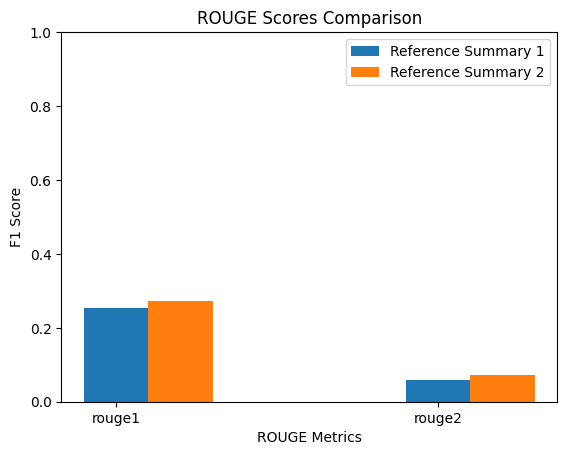

In [ ]:
import matplotlib.pyplot as plt

def plot_rouge_scores(rouge_scores):
    metrics = ["rouge1", "rouge2"]
    num_groups = len(rouge_scores)
    bar_width = 0.4 / num_groups

    for i, scores in enumerate(rouge_scores):
        plt.bar(
            [pos + bar_width * i for pos in range(len(metrics))],
            [scores[metric] for metric in metrics],
            width=bar_width,
            label=f"Reference Summary {i + 1}",
        )

    plt.xlabel("ROUGE Metrics")
    plt.ylabel("F1 Score")
    plt.title("ROUGE Scores Comparison")
    plt.xticks(range(len(metrics)), metrics)
    plt.legend()
    plt.ylim(0, 1)  # Set y-axis limits for F1 scores (0 to 1)
    plt.show()


plot_rouge_scores(rouge_results)